In [104]:
from settings import PROCESSED_DATA_DIR
import pandas as pd
from pathlib import Path
from reduce_memory_usage import reduce_memory_usage
from sklearn.metrics import precision_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [105]:
odds_df = pd.read_csv(Path(PROCESSED_DATA_DIR, 'bundesliga_1_odds.csv'))
odds_df = odds_df.rename(columns={'match_id': 'info_match_id'})
df = pd.read_csv(Path(PROCESSED_DATA_DIR, 'bundesliga_matches.csv'))
df = reduce_memory_usage(df)
df['info_date'] = pd.to_datetime(df['info_date'])
df = df.sort_values(by=['info_date'])

Memory usage of dataframe is 4.606128692626953 MB
Memory usage of dataframe after reduction 1.2233238220214844 MB
Reduced by 73.4413885573874 % 


In [106]:
models_performance_df = pd.DataFrame(
    columns=[
        'model',
        'average_precision',
        'max_precision',
        'low_precision',
        'high_precision',
        'time_elapsed'
    ]
)

In [107]:
def calc_profitability(x, bet=10):
    predicted_home_win = x['prediction_x'] == 1
    actual_home_win = x['actual_x'] == 1
    predicted_away_loss = x['prediction_y'] == 0
    actual_away_loss = x['actual_y'] == 0
    actual_away_win = x['actual_y'] == 1
    if actual_home_win and predicted_home_win and actual_away_loss and predicted_away_loss:
        # Depending on venue, calculate profit.
        if x['info_venue_x'] == 'Home':
            return x['b365h'] * bet - bet
        else:
            return x['b365a'] * bet - bet
    elif not actual_home_win and predicted_home_win and actual_away_win and predicted_away_loss:
        return -bet
    else:
        # Else don't place a bet.
        return 0

In [108]:
def predict(data, cutoff_date, model):
    """
    Make predictions using the random forest classifier.

    :param data: the dataframe to use
    :param cutoff_date: the date to use for splitting the data into train and test sets
    :param model: 
    :return: combined: a dataframe containing the actual and predicted values
    """
    # Pick the predictor columns.
    predictors = [c for c in data.columns if c.startswith('feat_')]

    test_cutoff_date = pd.to_datetime(cutoff_date) + pd.Timedelta(days=10)
    train_set = data[data['info_date'] < cutoff_date]
    test_set = data[(data['info_date'] >= cutoff_date) & (data['info_date'] < test_cutoff_date.strftime('%Y-%m-%d'))]

    print('From {} to {}'.format(cutoff_date, test_cutoff_date.strftime('%Y-%m-%d')))
    print(f'Train: {len(train_set)} matches ({len(train_set) / len(data):.2%})')
    print(f'Test: {len(test_set)} matches ({len(test_set) / len(data):.2%})')

    if len(test_set) == 0 or len(train_set) == 0:
        return -1, None

    # Fit (train) the model.
    model.fit(train_set[predictors], train_set['target'])

    # Make predictions on the test dataset and calculate the precision score.
    predictions = model.predict(test_set[predictors])
    precision = precision_score(test_set['target'], predictions, zero_division=np.nan)
    if np.isnan(precision):
        return -2, None
    print(f'Precision: {precision:.2%}')

    # Create a dataframe containing the actual and predicted values.
    combined = pd.DataFrame(
        dict(actual=test_set['target'], prediction=predictions),
        index=test_set.index
    )

    return precision, combined

In [109]:
def test_model(model, data):
    # Start time.
    start_time = pd.Timestamp.now()
    # Global variables to calculate average precision.
    tests_performed = 0
    precision_sum = 0
    # Low and high precision.
    low_precision = 1
    high_precision = 0
    # Start with cutoff_date of 2020-01-01.
    cutoff_date = '2020-01-01'
    # Store all combined dataframes in a list.
    combined_dfs = []
    # Iterate until cutoff_date is 2023-12-01.
    while cutoff_date != '2023-12-01':
        # Create a copy, so we don't modify the original by mistake.
        copy = data.copy()

        # Make the predictions.
        print('----------------------------------------')
        precision, combined = predict(copy, cutoff_date, model)
        print('----------------------------------------')

        # Increment cutoff date by 10 days for next iteration (if any).
        cutoff_date = pd.to_datetime(cutoff_date) + pd.Timedelta(days=10)
        cutoff_date = cutoff_date.strftime('%Y-%m-%d')

        # If the precision is -1, that means there were no matches to test on, continue.
        if precision == -1 or precision == -2:
            continue

        # Else add to global vars.
        tests_performed += 1
        precision_sum += precision
        if precision < low_precision:
            low_precision = precision
        if precision > high_precision:
            high_precision = precision
        # Add to list of combined dataframes.
        combined_dfs.append(combined)

    # Concatenate all combined dataframes into one.
    combined_df = pd.concat(combined_dfs)
    # Combine with the original dataframe to get the actual values.
    temp_df = data.copy().merge(
        combined_df,
        left_index=True,
        right_index=True
    )
    # Merge with itself to get the predictions of both teams in the same row.
    temp_df = temp_df.merge(
        temp_df, left_on=['info_date', 'info_team'], right_on=['info_date', 'info_opponent']
    )
    # Pick only the rows where one was predicted to win and the other to lose.
    precision_df = temp_df[(temp_df['prediction_x'] == 1) & (temp_df['prediction_y'] == 0)]['actual_x'].value_counts()
    max_precision = precision_df.iloc[0] / (precision_df.iloc[0] + precision_df.iloc[1])
    # Profitability dataframe.
    profitability_df = temp_df.copy()
    # Rename info_match_id_x to info_match_id.
    profitability_df = profitability_df.rename(columns={'info_match_id_x': 'info_match_id'})
    profitability_df = pd.merge(profitability_df, odds_df, on='info_match_id', how='left')
    profitability_df.insert(0,'profit',0)
    profitability_df['profit'] = profitability_df.apply(
        lambda x: calc_profitability(x, 10),
        axis=1
    )
    # Print time information.
    end_time = pd.Timestamp.now()
    print(f'Start time: {start_time}')
    print(f'End time: {end_time}')
    print(f'Time elapsed: {end_time - start_time}')
    print(f'Tests performed: {tests_performed}')
    # Calculate average precision.
    average_precision = precision_sum / tests_performed
    print(f'{model.__class__.__name__} Average precision: {average_precision:.2%}')
    print(f'{model.__class__.__name__} Max precision: {max_precision:.2%}')
    # Add to dataframe.
    models_performance_df.loc[len(models_performance_df)] = [
        model.__class__.__name__,
        average_precision,
        max_precision,
        low_precision,
        high_precision,
        end_time - start_time]
    # Return profitability dataframe.
    return profitability_df

# Trying Out Different Models

I am basing my picks based on what the people in [this research paper](https://www.sciencedirect.com/science/article/pii/S1877050922007955?ref=pdf_download&fr=RR-2&rr=8315f515892c66a9) did.

- Support Vector Machines (SVM)
- Xgboost
- RandomForest (RF)
- Multi Layer Perceptron (MLP)

## Support Vector Machines (SVM)

[On scikit learn](https://scikit-learn.org/stable/modules/svm.html)

A set of **supervised learning methods** used for **classification and regression**

Pros:
- Effective in high dimensional spaces (what we have)
- Memory efficient (not very crucial for us)
Cons:
- Does not directly give estimates though they can be obtained, but costly

In [110]:
from sklearn import svm

svc_profitability_df = test_model(svm.NuSVC(), df)

----------------------------------------
From 2020-01-01 to 2020-01-11
Train: 1464 matches (38.31%)
Test: 0 matches (0.00%)
----------------------------------------
----------------------------------------
From 2020-01-11 to 2020-01-21
Train: 1464 matches (38.31%)
Test: 18 matches (0.47%)
Precision: 54.55%
----------------------------------------
----------------------------------------
From 2020-01-21 to 2020-01-31
Train: 1482 matches (38.79%)
Test: 18 matches (0.47%)
Precision: 44.44%
----------------------------------------
----------------------------------------
From 2020-01-31 to 2020-02-10
Train: 1500 matches (39.26%)
Test: 34 matches (0.89%)
Precision: 30.00%
----------------------------------------
----------------------------------------
From 2020-02-10 to 2020-02-20
Train: 1534 matches (40.15%)
Test: 18 matches (0.47%)
Precision: 46.15%
----------------------------------------
----------------------------------------
From 2020-02-20 to 2020-03-01
Train: 1552 matches (40.62%)

## XGBoost (GradientBoostingClassifier)

[On scikit learn](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)

> Note: Xgboost is fundamentally the same as GradientBoostingClassifier, but it is faster and has more features.


In [111]:
from sklearn.ensemble import GradientBoostingClassifier

xboost_profitability_df = test_model(GradientBoostingClassifier(), df)

----------------------------------------
From 2020-01-01 to 2020-01-11
Train: 1464 matches (38.31%)
Test: 0 matches (0.00%)
----------------------------------------
----------------------------------------
From 2020-01-11 to 2020-01-21
Train: 1464 matches (38.31%)
Test: 18 matches (0.47%)
Precision: 80.00%
----------------------------------------
----------------------------------------
From 2020-01-21 to 2020-01-31
Train: 1482 matches (38.79%)
Test: 18 matches (0.47%)
Precision: 75.00%
----------------------------------------
----------------------------------------
From 2020-01-31 to 2020-02-10
Train: 1500 matches (39.26%)
Test: 34 matches (0.89%)
Precision: 36.36%
----------------------------------------
----------------------------------------
From 2020-02-10 to 2020-02-20
Train: 1534 matches (40.15%)
Test: 18 matches (0.47%)
Precision: 75.00%
----------------------------------------
----------------------------------------
From 2020-02-20 to 2020-03-01
Train: 1552 matches (40.62%)

## RandomForest (RF)

[On scikit learn](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

In [112]:
from sklearn.ensemble import RandomForestClassifier

rf_profitability_df = test_model(RandomForestClassifier(), df)

----------------------------------------
From 2020-01-01 to 2020-01-11
Train: 1464 matches (38.31%)
Test: 0 matches (0.00%)
----------------------------------------
----------------------------------------
From 2020-01-11 to 2020-01-21
Train: 1464 matches (38.31%)
Test: 18 matches (0.47%)
Precision: 80.00%
----------------------------------------
----------------------------------------
From 2020-01-21 to 2020-01-31
Train: 1482 matches (38.79%)
Test: 18 matches (0.47%)
Precision: 75.00%
----------------------------------------
----------------------------------------
From 2020-01-31 to 2020-02-10
Train: 1500 matches (39.26%)
Test: 34 matches (0.89%)
Precision: 42.86%
----------------------------------------
----------------------------------------
From 2020-02-10 to 2020-02-20
Train: 1534 matches (40.15%)
Test: 18 matches (0.47%)
Precision: 100.00%
----------------------------------------
----------------------------------------
From 2020-02-20 to 2020-03-01
Train: 1552 matches (40.62%

## Multi Layer Perceptron (MLP)

[On scikit learn](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier)

> Note: Scikit is not meant for large deep learning models, so we will not be using this for our final model.

The default solver ‘adam’ works pretty well on relatively large datasets (with thousands of training samples or more) in terms of both training time and validation score. For small datasets, however, ‘lbfgs’ can converge faster and perform better.

In [113]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

# Scale input data.
data = df.copy()
scaler = StandardScaler()
# Scale all columns that start with 'feat_'.
cols_to_scale = data.columns[data.columns.str.startswith('feat_')]
data[cols_to_scale] = scaler.fit_transform(data[cols_to_scale])

mlp_profitability_df = test_model(
    MLPClassifier(
        solver='adam',
        hidden_layer_sizes=(50, 10),
        max_iter=1000,
    ),
    data
)

----------------------------------------
From 2020-01-01 to 2020-01-11
Train: 1464 matches (38.31%)
Test: 0 matches (0.00%)
----------------------------------------
----------------------------------------
From 2020-01-11 to 2020-01-21
Train: 1464 matches (38.31%)
Test: 18 matches (0.47%)
Precision: 50.00%
----------------------------------------
----------------------------------------
From 2020-01-21 to 2020-01-31
Train: 1482 matches (38.79%)
Test: 18 matches (0.47%)
Precision: 66.67%
----------------------------------------
----------------------------------------
From 2020-01-31 to 2020-02-10
Train: 1500 matches (39.26%)
Test: 34 matches (0.89%)
Precision: 37.50%
----------------------------------------
----------------------------------------
From 2020-02-10 to 2020-02-20
Train: 1534 matches (40.15%)
Test: 18 matches (0.47%)
Precision: 36.36%
----------------------------------------
----------------------------------------
From 2020-02-20 to 2020-03-01
Train: 1552 matches (40.62%)

## Visualize Results

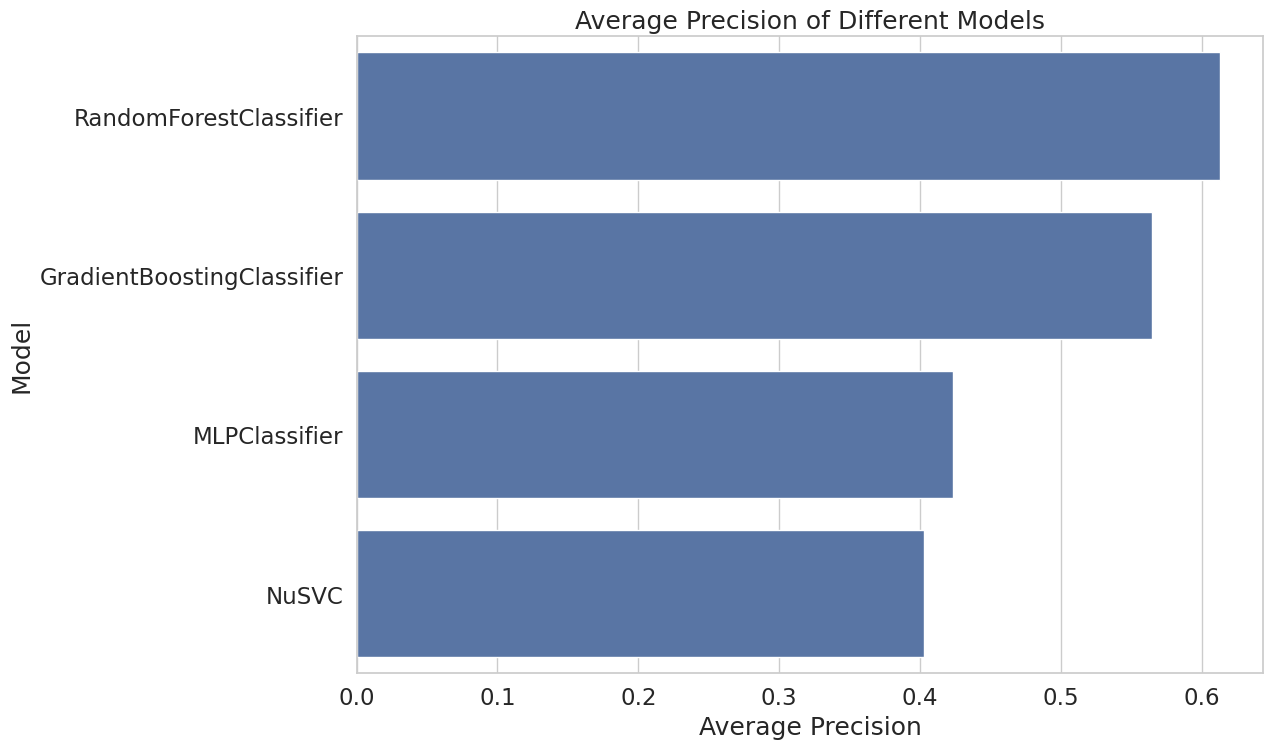

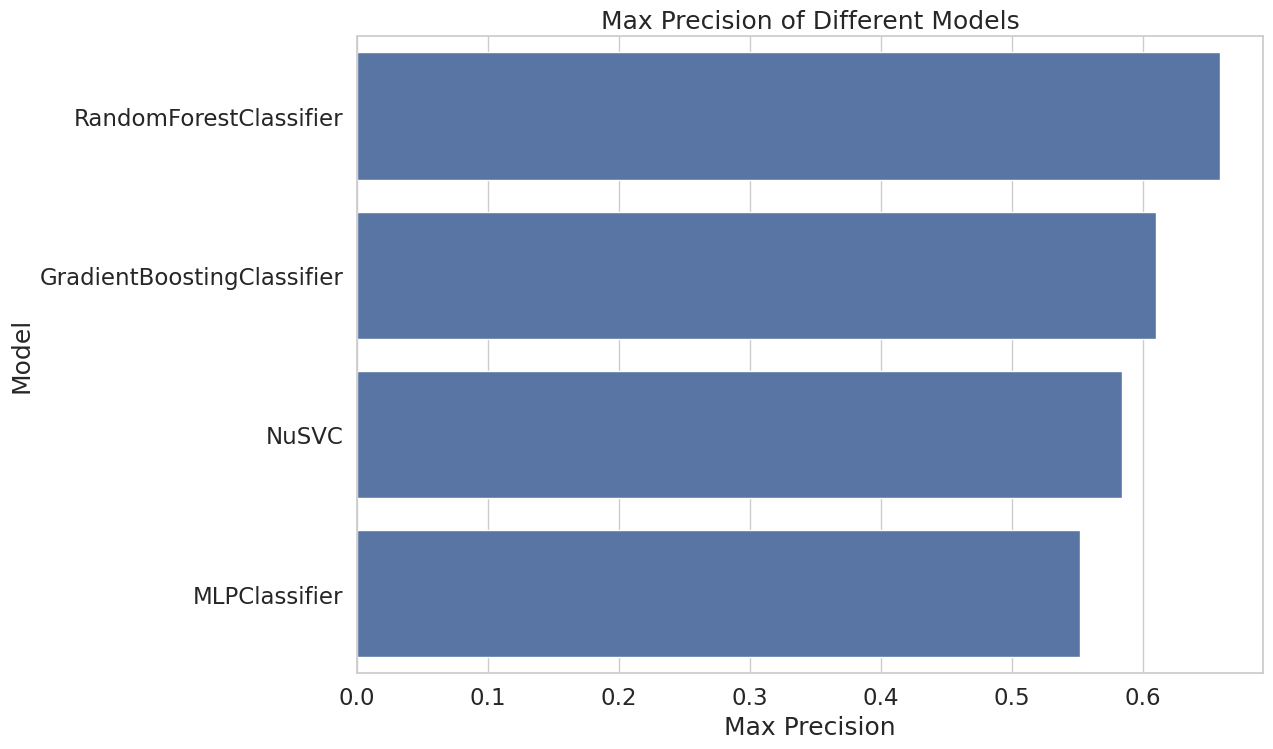

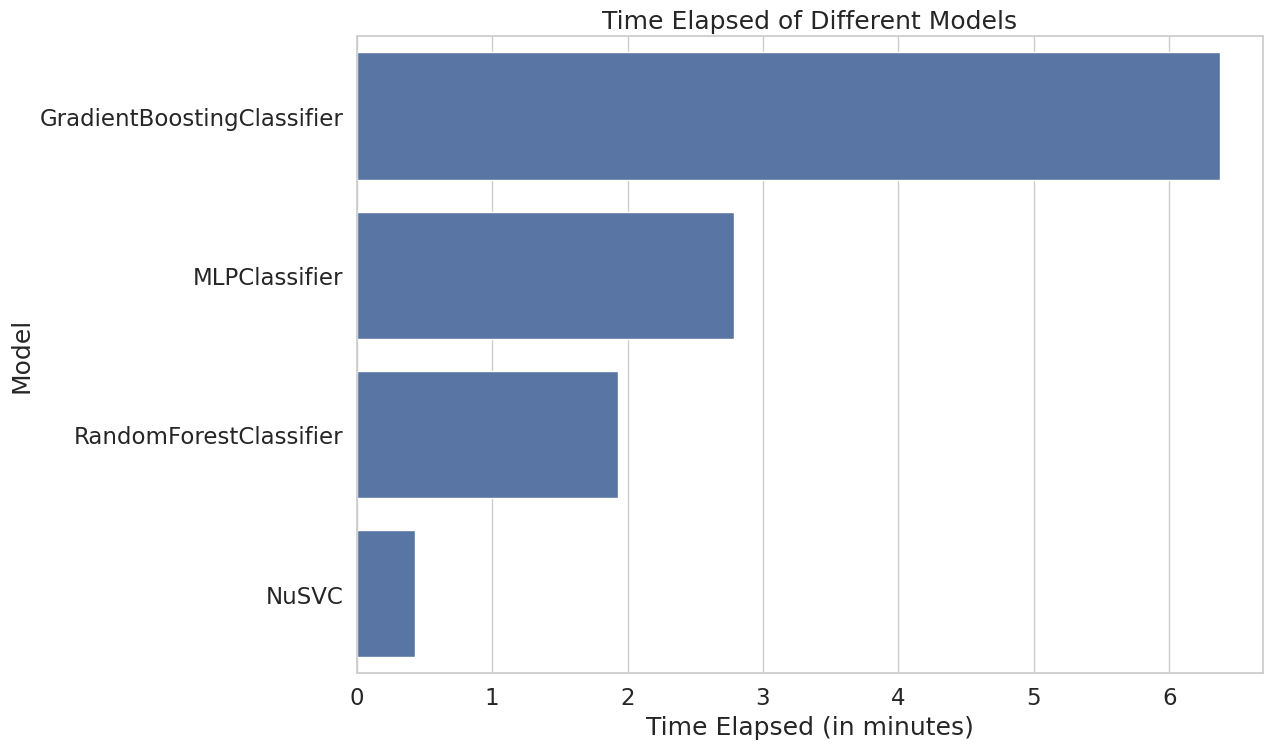

In [114]:
sns.set_theme(style="whitegrid")
sns.set(font_scale=1.5)
sns.set_style("ticks")
sns.set_style("whitegrid")

avg_precision_order = models_performance_df.sort_values(by=['average_precision'], ascending=False)['model']
ax = sns.barplot(x="average_precision", y="model", data=models_performance_df, order=avg_precision_order)
ax.set(xlabel='Average Precision', ylabel='Model')
ax.set_title('Average Precision of Different Models')
plt.show()

max_precision_order = models_performance_df.sort_values(by=['max_precision'], ascending=False)['model']
ax = sns.barplot(x="max_precision", y="model", data=models_performance_df, order=max_precision_order)
ax.set(xlabel='Max Precision', ylabel='Model')
ax.set_title('Max Precision of Different Models')
plt.show()

copy = models_performance_df.copy()
copy['time_elapsed_numeric'] = copy['time_elapsed'].dt.total_seconds() / 60.0
time_elapsed_order = copy.sort_values(by=['time_elapsed_numeric'], ascending=False)['model']
ax = sns.barplot(x="time_elapsed_numeric", y="model", data=copy, order=time_elapsed_order)
ax.set(xlabel='Time Elapsed (in minutes)', ylabel='Model')
ax.set_title('Time Elapsed of Different Models')
plt.show()

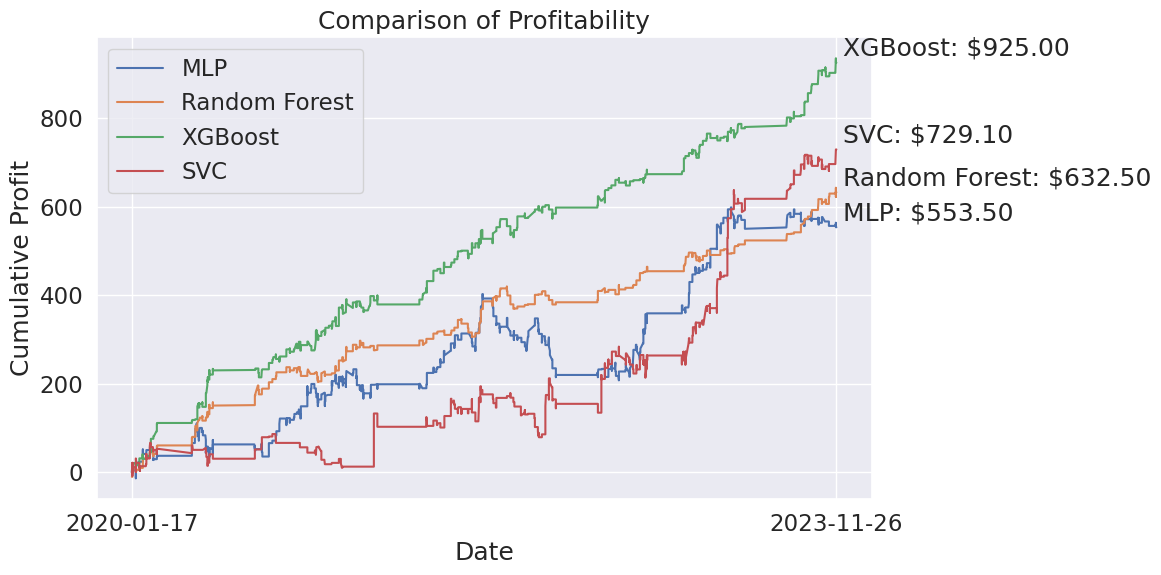

In [117]:
# Set up the figure and axis
sns.set_style('darkgrid')
plt.figure(figsize=(10, 6))

# Plot each DataFrame
plt.plot(mlp_profitability_df['info_date'], mlp_profitability_df['profit'].cumsum(), label='MLP')
plt.plot(rf_profitability_df['info_date'], rf_profitability_df['profit'].cumsum(), label='Random Forest')
plt.plot(xboost_profitability_df['info_date'], xboost_profitability_df['profit'].cumsum(), label='XGBoost')
plt.plot(svc_profitability_df['info_date'], svc_profitability_df['profit'].cumsum(), label='SVC')

# Customize the plot
plt.title('Comparison of Profitability')
plt.xlabel('Date')
plt.ylabel('Cumulative Profit')

# Set x-axis ticks to the earliest and latest dates
earliest_date = min(
    mlp_profitability_df['info_date'].min(),
    rf_profitability_df['info_date'].min(),
    xboost_profitability_df['info_date'].min(),
    svc_profitability_df['info_date'].min()
)

latest_date = max(
    mlp_profitability_df['info_date'].max(),
    rf_profitability_df['info_date'].max(),
    xboost_profitability_df['info_date'].max(),
    svc_profitability_df['info_date'].max()
)

plt.xticks([earliest_date, latest_date])

# Add legend with labels from the 'label' parameter in the plot function
plt.legend()

# Annotate the end points with cumulative sum values
for df, label in zip([mlp_profitability_df, rf_profitability_df, xboost_profitability_df, svc_profitability_df], ['MLP', 'Random Forest', 'XGBoost', 'SVC']):
    final_cumsum = df['profit'].cumsum().iloc[-1]
    plt.annotate(f'{label}: ${final_cumsum:.2f}', xy=(df['info_date'].iloc[-1], final_cumsum), textcoords='offset points', xytext=(5,5), ha='left')

plt.show()

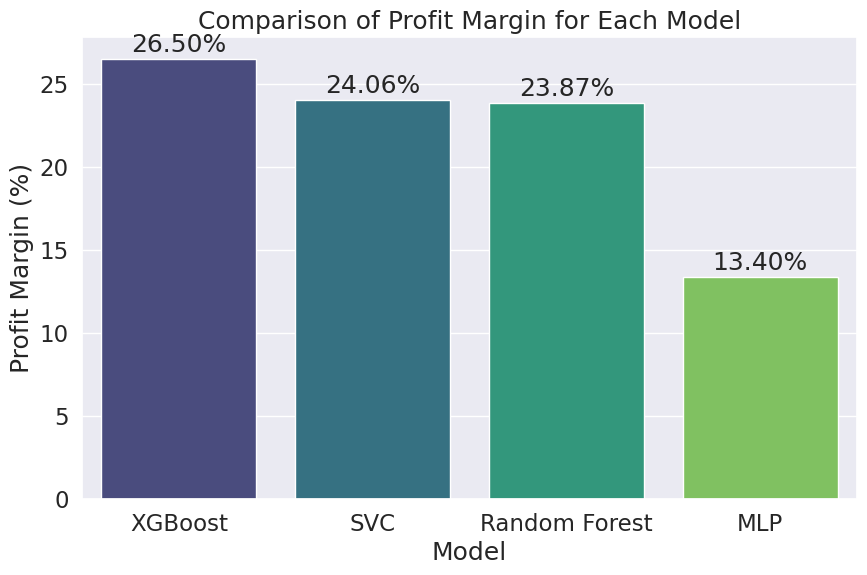

In [122]:
models = ['MLP', 'Random Forest', 'XGBoost', 'SVC']
dfs = [mlp_profitability_df, rf_profitability_df, xboost_profitability_df, svc_profitability_df]

bets_placed = [df['profit'].ne(0).sum() for df in dfs]
profit = [df['profit'].sum() for df in dfs]

# Calculate profit margin for each model
bet_amount = 10
profit_margin = [(p / (b * bet_amount)) * 100 for p, b in zip(profit, bets_placed)]

# Create a DataFrame for easy plotting
profit_margin_df = pd.DataFrame({'Model': models, 'Profit Margin': profit_margin})

# Sort the DataFrame by Profit Margin in descending order
profit_margin_df = profit_margin_df.sort_values(by='Profit Margin', ascending=False)

# Set up the figure and axis
sns.set_style('darkgrid')
plt.figure(figsize=(10, 6))

# Plot the bar chart
ax = sns.barplot(x='Model', y='Profit Margin', data=profit_margin_df, palette='viridis', hue='Model')

# Add profit margin values on top of the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Customize the plot
plt.title('Comparison of Profit Margin for Each Model')
plt.xlabel('Model')
plt.ylabel('Profit Margin (%)')

plt.show()

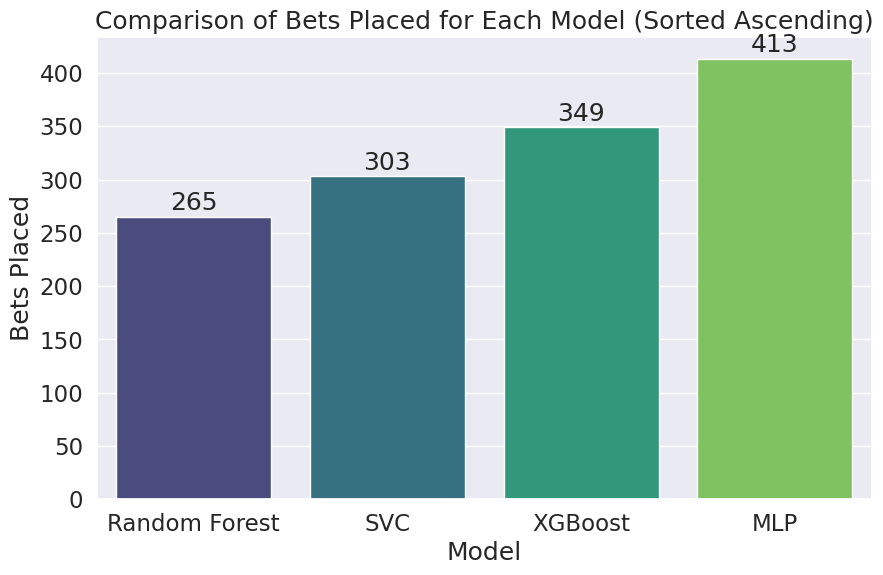

In [124]:
models = ['MLP', 'Random Forest', 'XGBoost', 'SVC']
dfs = [mlp_profitability_df, rf_profitability_df, xboost_profitability_df, svc_profitability_df]

bets_placed = [df['profit'].ne(0).sum() for df in dfs]

# Create a DataFrame for easy plotting
bets_placed_df = pd.DataFrame({'Model': models, 'Bets Placed': bets_placed})

# Sort the DataFrame by Bets Placed in ascending order
bets_placed_df = bets_placed_df.sort_values(by='Bets Placed', ascending=True)

# Set up the figure and axis
sns.set_style('darkgrid')
plt.figure(figsize=(10, 6))

# Plot the bar chart
ax = sns.barplot(x='Model', y='Bets Placed', data=bets_placed_df, palette='viridis', hue='Model')

# Add bet amounts on top of the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Customize the plot
plt.title('Comparison of Bets Placed for Each Model (Sorted Ascending)')
plt.xlabel('Model')
plt.ylabel('Bets Placed')

plt.show()